# INF-395 Redes Neuronales Artificiales
## Tarea 1 - Redes Neuro

### Integrantes:
* Ignacio Valenzuela
* Rodrigo González Smith 201303026-2

## Pregunta 2 - Deep Networks

In [166]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras import backend as K
import tensorflow as tf
import keras
from sklearn import model_selection
import matplotlib as plt
from keras.models import model_from_json
import os
import h5py
import seaborn as sns
%matplotlib inline

In [2]:
datos= pd.read_csv("roboBohr.csv")
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

### a) 
Procedemos a trabajar con $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas. Transformamos para el set de entrenamiento, validación  y test. Todo para nuestras pruebas posteriores.

In [3]:
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
X_val_scaled = pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
y_val_scaled = X_val_scaled.pop('Eat').values.reshape(-1,1)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_val.columns)
y_test_scaled = X_test_scaled.pop('Eat').values.reshape(-1,1)

y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)
y_test = df_test.pop('Eat').values.reshape(-1,1)

### 2.b Gradiente y pesos en red poco profunda

#### Pre entrenamiento

Hacemos cambios necesarios debido a la versión de Python que estamos usando.

In [4]:
a = np.matrix(X_train_scaled)
a_val_scaled = np.matrix(X_val_scaled)

Ahora usaremos el mismo modelo del inciso b) de la pregunta 1, iniciando con pesos uniformes. Posteriormente calcularemos los gradientes para el modelo antes y después de entrenar la red, con el fin de observar sus cambios. Notamos que se inicializa la red con pesos bajo la distribución uniforme, ahora procedemos a obtener los gradientes antes de entrenar:

In [51]:
model_2_b = Sequential()
model_2_b.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model_2_b.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model_2_b.compile(optimizer=sgd,loss='mean_squared_error')


 ###calculate gradients
loss_2_b_pre = keras.losses.mean_squared_error(model_2_b.output,y_train_scaled)
listOfVariableTensors_2_b_pre = model_2_b.trainable_weights 
gradients_2_b_pre = K.gradients(loss_2_b_pre, listOfVariableTensors_2_b_pre) #We can now calculate the gradients.
sess_2_b_pre = K.get_session()
evaluated_gradients_2_b_pre = sess_2_b_pre.run(gradients_2_b_pre,feed_dict={model_2_b.input:X_train_scaled.values})
evaluated_gradients_2_b_pre = [gradient/len(y_train) for gradient in evaluated_gradients_2_b_pre]

In [52]:
W_1_b_pre = np.concatenate((model_2_b.get_weights()[0],np.matrix(model_2_b.get_weights()[1])),axis=0)
W_1_b_pre_mean = np.mean((W_1_b_pre),axis=1)
W_2_b_pre = np.concatenate((model_2_b.get_weights()[2],np.matrix(model_2_b.get_weights()[3])),axis=0)
G_1_b_pre = np.concatenate((evaluated_gradients_2_b_pre[0],np.matrix(evaluated_gradients_2_b_pre[1])),axis=0)
G_1_b_pre_mean = np.mean((G_1_b_pre),axis=1)
G_2_b_pre = np.concatenate((evaluated_gradients_2_b_pre[2],np.matrix(evaluated_gradients_2_b_pre[3])),axis=0)
#flat_list = np.asarray(G_1_b_pre.flatten())

Así guardamos tanto los pesos como los gradientes en variables para el pre entrenamiento.

#### Post Training

In [8]:
history_2_b = model_2_b.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val))
model_2_b_json = model_2_b.to_json()
with open("modelos/model_2_b.json", "w") as json_file:
    json_file.write(model_2_b_json)
model_2_b.save_weights("modelos/model_2_b.h5")


 ###calculate gradients
loss_2_b_post = keras.losses.mean_squared_error(model_2_b.output,y_train_scaled)
listOfVariableTensors_2_b_post = model_2_b.trainable_weights 
gradients_2_b_post = K.gradients(loss_2_b_post, listOfVariableTensors_2_b_post) #We can now calculate the gradients.
sess_2_b_post = K.get_session()
evaluated_gradients_2_b_post = sess_2_b_post.run(gradients_2_b_post,feed_dict={model_2_b.input:X_train_scaled.values})
evaluated_gradients_2_b_post = [gradient/len(y_train) for gradient in evaluated_gradients_2_b_post]

Para no tener que entrenar nuevamente se guardó el modelo en un archivo, notar que guardarmos los archivos de entrenamiento de las redes dado que estos son los que toman tiempos prolongados de ejecución:

In [43]:
json_file = open('modelos/model_2_b.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2_b = model_from_json(loaded_model_json)
# load weights into new model
model_2_b.load_weights("modelos/model_2_b.h5")

In [44]:
W_1_b_post = np.concatenate((model_2_b.get_weights()[0],np.matrix(model_2_b.get_weights()[1])),axis=0)
W_1_b_post_mean = np.mean((W_1_b_post),axis=1)
W_2_b_post = np.concatenate((model_2_b.get_weights()[2],np.matrix(model_2_b.get_weights()[3])),axis=0)
G_1_b_post = np.concatenate((evaluated_gradients_2_b_post[0],np.matrix(evaluated_gradients_2_b_post[1])),axis=0)
G_1_b_post_mean = np.mean((G_1_b_post),axis=1)
G_2_b_post = np.concatenate((evaluated_gradients_2_b_post[2],np.matrix(evaluated_gradients_2_b_post[3])),axis=0)

Así guardamos tanto los pesos como los gradientes en variables para el post entrenamiento.

#### Visualizaciones

Ahora con los gradientes y pesos de los modelos pre y post entrenamiento, podemos hacer una comparación de sus cambios respectivos.

#####  Gradientes

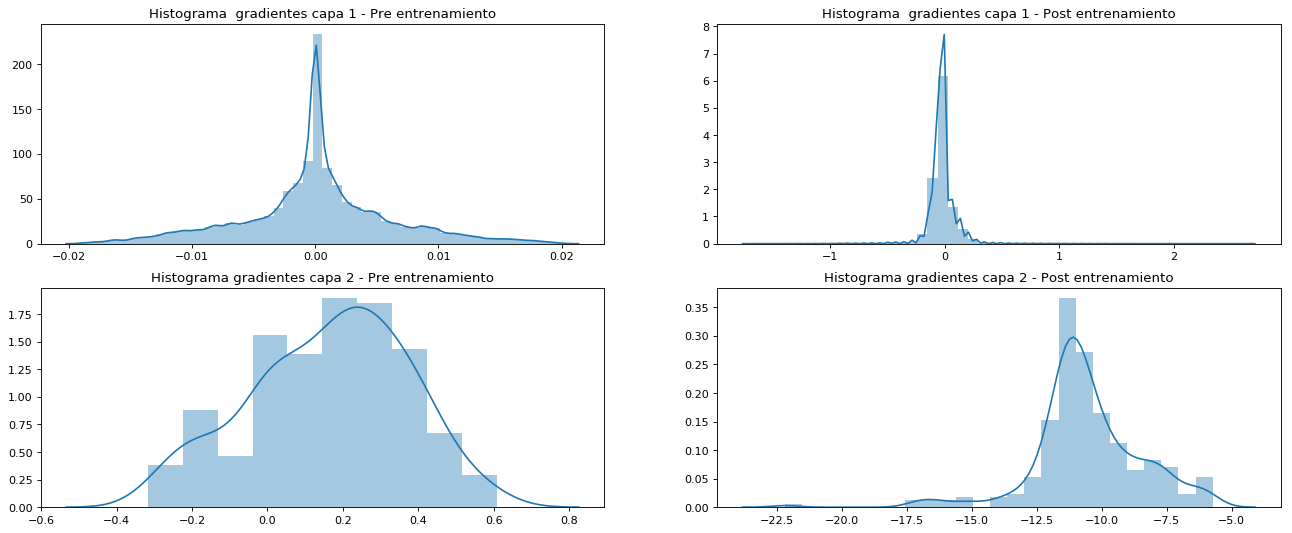

In [252]:
plt.pyplot.figure(figsize=(20, 8), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(2,2,1)
plt.pyplot.title("Histograma  gradientes capa 1 - Pre entrenamiento")
flat_list = np.asarray(G_1_b_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)

plt.pyplot.subplot(2,2,2)
plt.pyplot.title("Histograma  gradientes capa 1 - Post entrenamiento")
flat_list = np.asarray(G_1_b_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(2,2,3)
plt.pyplot.title("Histograma gradientes capa 2 - Pre entrenamiento")
flat_list = np.asarray(G_2_b_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(2,2,4)
plt.pyplot.title("Histograma gradientes capa 2 - Post entrenamiento")
flat_list = np.asarray(G_2_b_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)

Donde se puede apreciar que los gradientes para el Input a la primera capa escondida siguen la distribución lineal, en cambio los siguientes correspondientes a los pesos de la capa escondida al output son menos y están más dispersos. También se puede ver que después de entrenar, los rangos aumentas y la distribución es más dispersa.

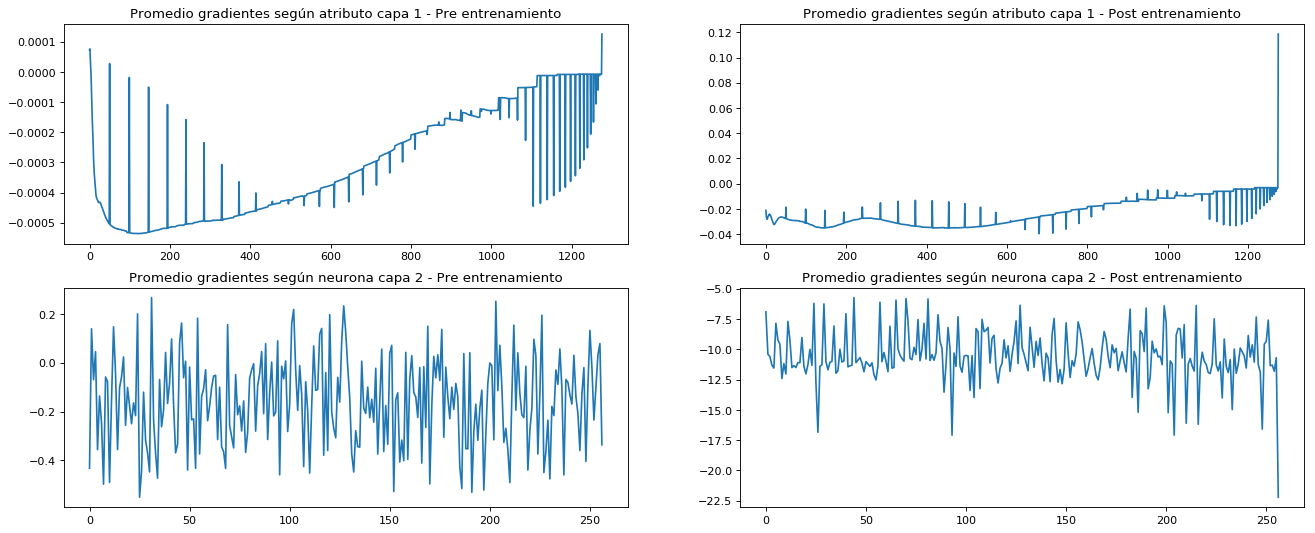

In [48]:
plt.pyplot.figure(figsize=(20, 8), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(2,2,1)
plt.pyplot.title("Promedio gradientes según atributo capa 1 - Pre entrenamiento")
_ = plt.pyplot.plot(G_1_b_pre_mean)
plt.pyplot.subplot(2,2,2)
plt.pyplot.title("Promedio gradientes según atributo capa 1 - Post entrenamiento")
_ = plt.pyplot.plot(G_1_b_post_mean)
plt.pyplot.subplot(2,2,3)
plt.pyplot.title("Promedio gradientes según neurona capa 2 - Pre entrenamiento")
_ = plt.pyplot.plot(G_2_b_pre)
plt.pyplot.subplot(2,2,4)
plt.pyplot.title("Promedio gradientes según neurona capa 2 - Post entrenamiento")
_ = plt.pyplot.plot(G_2_b_post)

Se puede apreciar en la primera capa de Input como algunos valores tienen mucho más peso, lo que se ve reflejado en el promedio de sus pesos y de como se diferencian cualitativamente.

#### Pesos

Ahora compararemos los pesos en las capas por medio de un histograma para ver la frecuencia de los valores, como también de un promedio de los pesos según dato o neurona.

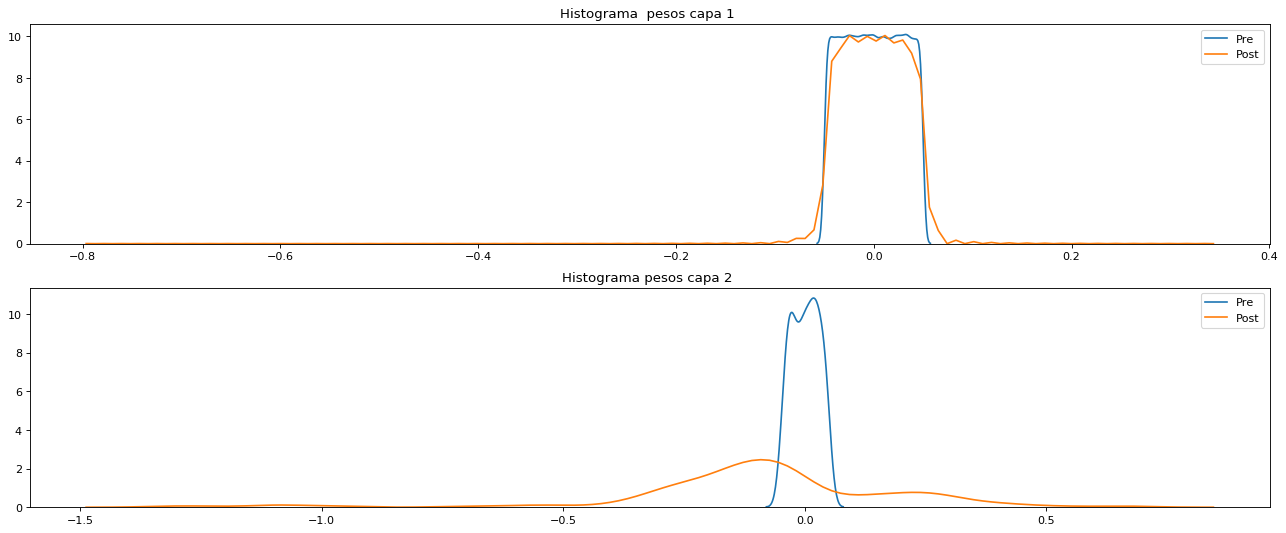

In [239]:
plt.pyplot.figure(figsize=(20, 8), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(2,1,1)
plt.pyplot.title("Histograma  pesos capa 1 ")
flat_list = np.asarray(W_1_b_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_1_b_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(2,1,2)
plt.pyplot.title("Histograma pesos capa 2 ")
flat_list = np.asarray(W_2_b_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_2_b_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")


Se puede ver que en la primera capa hay valores que se mantiene similares en frecuencia, posiblemente la red no tuvo que variar los pesos de los Inputs en general. Para la segunda capa se ve una mayor dispersión de los pesos.

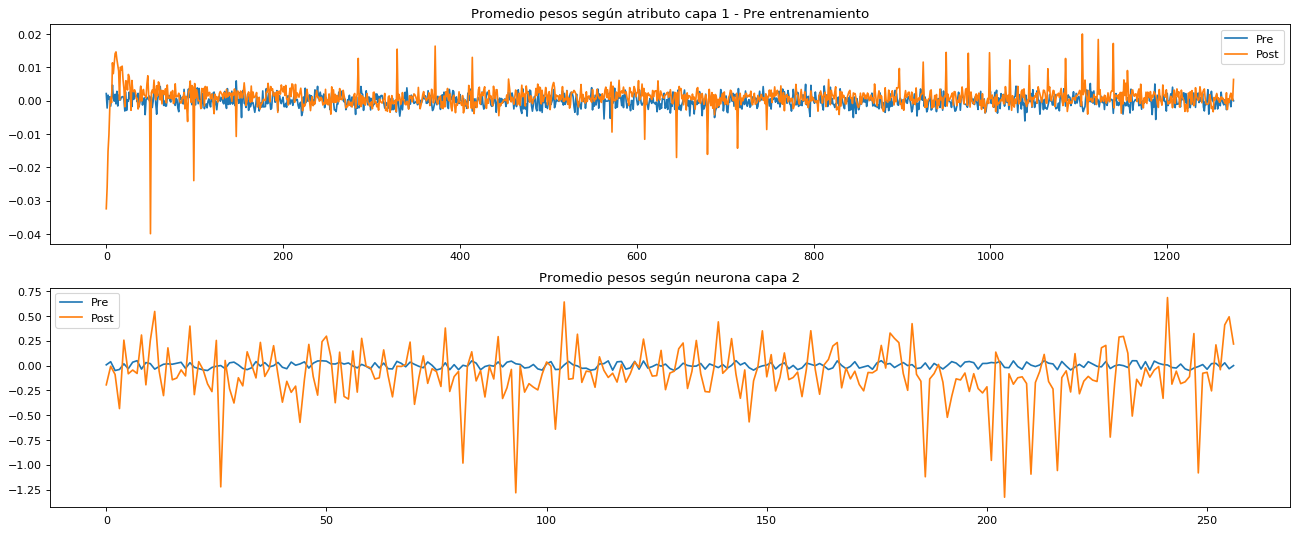

In [244]:
plt.pyplot.figure(figsize=(20, 8), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(2,1,1)
plt.pyplot.title("Promedio pesos según atributo capa 1 - Pre entrenamiento")
_ = plt.pyplot.plot(W_1_b_pre_mean,label="Pre")
_ = plt.pyplot.plot(W_1_b_post_mean,label="Post")
plt.pyplot.legend()
plt.pyplot.subplot(2,1,2)
plt.pyplot.title("Promedio pesos según neurona capa 2")
_ = plt.pyplot.plot(W_2_b_pre,label="Pre")
_ = plt.pyplot.plot(W_2_b_post,label="Post")
plt.pyplot.legend()

Ahora bien analizando los pesos para cada capa, notamos que para los atributos del Input hay algunos que sobresalen por el promedio de sus pesos, significando su importancia en la regresion. Por otro lado para la capa 2, se refleja lo visto anteriormente dado que los pesos para cada neurona no tienen valores tan semejantes.

### 2.c  Red profunda  uniform + Sigmoid

Ahora procedemos a entrenar una red con 5 capas escondidas, utilizando la distribución 'uniform' para  inicializar los pesos al igual que anteriormente.

#### Pre Entrenamiento

In [69]:
model_2_c = Sequential()
model_2_c.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model_2_c.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model_2_c.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
model_2_c.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model_2_c.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model_2_c.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model_2_c.compile(optimizer=sgd,loss='mean_squared_error')

 ###calculate gradients
loss_2_c_pre = keras.losses.mean_squared_error(model_2_c.output,y_train_scaled)
listOfVariableTensors_2_c_pre = model_2_c.trainable_weights 
gradients_2_c_pre = K.gradients(loss_2_c_pre, listOfVariableTensors_2_c_pre) #We can now calculate the gradients.
sess_2_c_pre = K.get_session()
evaluated_gradients_2_c_pre = sess_2_c_pre.run(gradients_2_c_pre,feed_dict={model_2_c.input:X_train_scaled.values})
evaluated_gradients_2_c_pre = [gradient/len(y_train) for gradient in evaluated_gradients_2_c_pre]

In [70]:
W_1_c_pre = np.concatenate((model_2_c.get_weights()[0],np.matrix(model_2_c.get_weights()[1])),axis=0)
W_1_c_pre_mean = np.mean((W_1_c_pre),axis=1)
W_2_c_pre = np.concatenate((model_2_c.get_weights()[2],np.matrix(model_2_c.get_weights()[3])),axis=0)
W_2_c_pre_mean = np.mean((W_2_c_pre),axis=1)
W_3_c_pre = np.concatenate((model_2_c.get_weights()[4],np.matrix(model_2_c.get_weights()[5])),axis=0)
W_3_c_pre_mean = np.mean((W_3_c_pre),axis=1)
G_1_c_pre = np.concatenate((evaluated_gradients_2_c_pre[0],np.matrix(evaluated_gradients_2_c_pre[1])),axis=0)
G_1_c_pre_mean = np.mean((G_1_c_pre),axis=1)
G_2_c_pre = np.concatenate((evaluated_gradients_2_c_pre[2],np.matrix(evaluated_gradients_2_c_pre[3])),axis=0)
G_2_c_pre_mean = np.mean((G_2_c_pre),axis=1)
G_3_c_pre = np.concatenate((evaluated_gradients_2_c_pre[4],np.matrix(evaluated_gradients_2_c_pre[5])),axis=0)
G_3_c_pre_mean = np.mean((G_3_c_pre),axis=1)

#### Post Training

In [60]:
history_2_c = model_2_c.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val))
model_2_c_json = model_2_c.to_json()
with open("modelos/model_2_c.json", "w") as json_file:
    json_file.write(model_2_c_json)
    model_2_c.save_weights("modelos/model_2_c.h5")   
    
###calculate gradients
loss_2_c_post = keras.losses.mean_squared_error(model_2_c.output,y_train_scaled)
listOfVariableTensors_2_c_post = model_2_c.trainable_weights 
gradients_2_c_post = K.gradients(loss_2_c_post, listOfVariableTensors_2_c_post) #We can now calculate the gradients.
sess_2_c_post = K.get_session()
evaluated_gradients_2_c_post = sess_2_c_post.run(gradients_2_c_post,feed_dict={model_2_c.input:X_train_scaled.values})
evaluated_gradients_2_c_post = [gradient/len(y_train) for gradient in evaluated_gradients_2_c_post]

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.4620 - val_loss: 0.4271
Epoch 2/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.4234 - val_loss: 0.4861
Epoch 3/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.4098 - val_loss: 0.9211
Epoch 4/250
9745/9745 [==============================] - 2s 246us/step - loss: 0.3556 - val_loss: 0.2761
Epoch 5/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.3280 - val_loss: 0.3621
Epoch 6/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.3092 - val_loss: 0.2879
Epoch 7/250
9745/9745 [==============================] - 2s 239us/step - loss: 0.2439 - val_loss: 0.2087
Epoch 8/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.2875 - val_loss: 0.2191
Epoch 9/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.2390 - val_loss: 0.1899
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.0483 - val_loss: 0.0520
Epoch 79/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.0467 - val_loss: 0.0715
Epoch 80/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0414 - val_loss: 0.0534
Epoch 81/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.0483 - val_loss: 0.0604
Epoch 82/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.0429 - val_loss: 0.0511
Epoch 83/250
9745/9745 [==============================] - 2s 239us/step - loss: 0.0422 - val_loss: 0.0952
Epoch 84/250
9745/9745 [==============================] - 2s 246us/step - loss: 0.0454 - val_loss: 0.0531
Epoch 85/250
9745/9745 [==============================] - 2s 244us/step - loss: 0.0494 - val_loss: 0.0475
Epoch 86/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.0450 - val_loss: 0.0564
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0336 - val_loss: 0.0773
Epoch 156/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0254 - val_loss: 0.0580
Epoch 157/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0278 - val_loss: 0.0391
Epoch 158/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.0270 - val_loss: 0.0538
Epoch 159/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0324 - val_loss: 0.0400
Epoch 160/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0307 - val_loss: 0.0503
Epoch 161/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0262 - val_loss: 0.0417
Epoch 162/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0304 - val_loss: 0.0468
Epoch 163/250
9745/9745 [==============================] - 2s 240us/step - loss: 0.0280 - val_loss: 0.0580
Epoch 164/250
9745/9745 [============

In [71]:
json_file = open('modelos/model_2_c.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2_c = model_from_json(loaded_model_json)
# load weights into new model
model_2_c.load_weights("modelos/model_2_c.h5")

In [67]:
W_1_c_post = np.concatenate((model_2_c.get_weights()[0],np.matrix(model_2_c.get_weights()[1])),axis=0)
W_1_c_post_mean = np.mean((W_1_c_post),axis=1)
W_2_c_post = np.concatenate((model_2_c.get_weights()[2],np.matrix(model_2_c.get_weights()[3])),axis=0)
W_2_c_post_mean = np.mean((W_2_c_post),axis=1)
W_3_c_post = np.concatenate((model_2_c.get_weights()[4],np.matrix(model_2_c.get_weights()[5])),axis=0)
W_3_c_post_mean = np.mean((W_3_c_post),axis=1)
G_1_c_post = np.concatenate((evaluated_gradients_2_c_post[0],np.matrix(evaluated_gradients_2_c_post[1])),axis=0)
G_1_c_post_mean = np.mean((G_1_c_post),axis=1)
G_2_c_post = np.concatenate((evaluated_gradients_2_c_post[2],np.matrix(evaluated_gradients_2_c_post[3])),axis=0)
G_2_c_post_mean = np.mean((G_2_c_post),axis=1)
G_3_c_post = np.concatenate((evaluated_gradients_2_c_post[4],np.matrix(evaluated_gradients_2_c_post[5])),axis=0)
G_3_c_post_mean = np.mean((G_3_c_post),axis=1)

Ahora se analizan los gradientes y pesos para las primeras 3 capas de la red, para poder verificar el efecto del gradiente desvaneciente y ver si en realidad se dejan de afectar los pesos en las capas iniciales.

#### Visualizaciones

Ahora con los gradientes y pesos de los modelos pre y post entrenamiento, podemos hacer una comparación de sus cambios respectivos.

#####  Gradientes

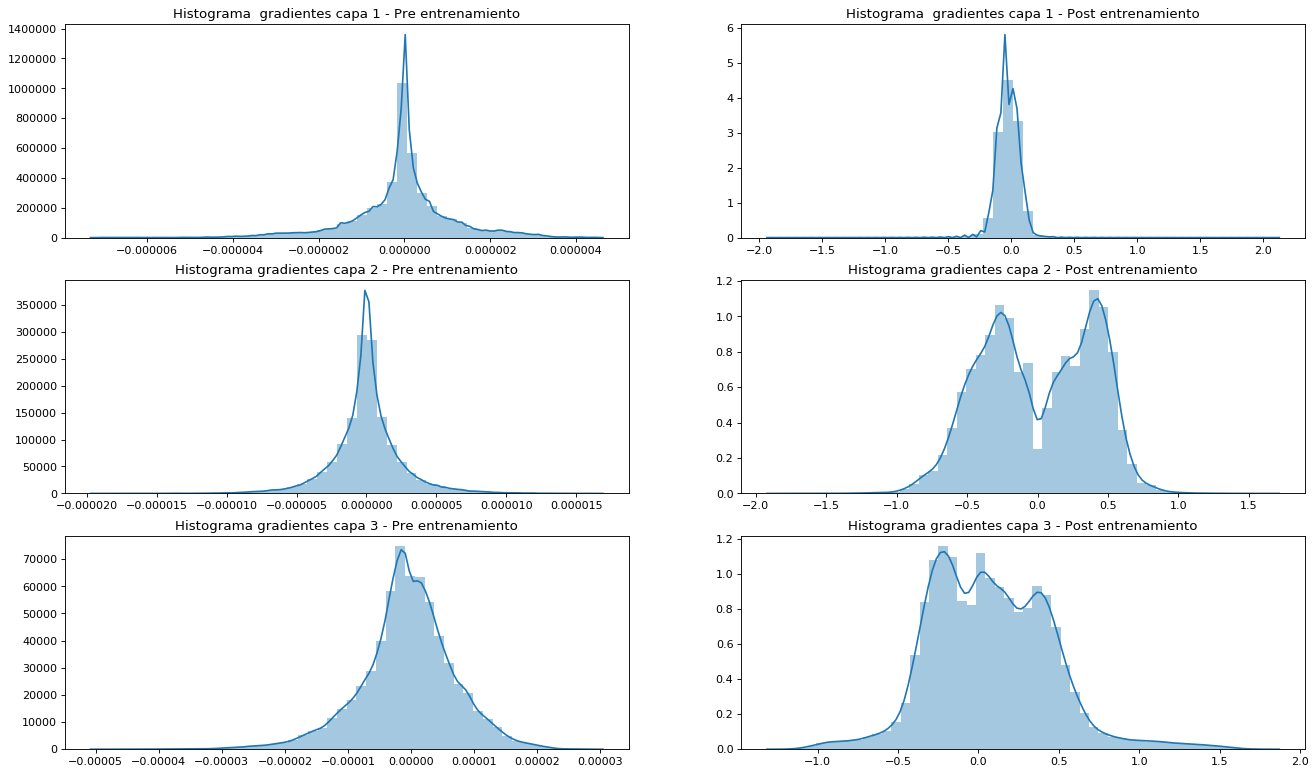

In [253]:
plt.pyplot.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,2,1)
plt.pyplot.title("Histograma  gradientes capa 1 - Pre entrenamiento")
flat_list = np.asarray(G_1_c_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,2)
plt.pyplot.title("Histograma  gradientes capa 1 - Post entrenamiento")
flat_list = np.asarray(G_1_c_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,3)
plt.pyplot.title("Histograma gradientes capa 2 - Pre entrenamiento")
flat_list = np.asarray(G_2_c_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,4)
plt.pyplot.title("Histograma gradientes capa 2 - Post entrenamiento")
flat_list = np.asarray(G_2_c_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,5)
plt.pyplot.title("Histograma gradientes capa 3 - Pre entrenamiento")
flat_list = np.asarray(G_3_c_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,6)
plt.pyplot.title("Histograma gradientes capa 3 - Post entrenamiento")
flat_list = np.asarray(G_3_c_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)

Podemos ver una tendencia general a que el rango de valores de la distribución de gradientes se tienda a agrandar, claramente al ser uniforme la inicialización las figuras para el pre-entrenamiento tendrán una forma similar. Notamos que hay poca tendencia a gradientes igual a 0 en los pesos de la capa 2 después del entrenamiento.

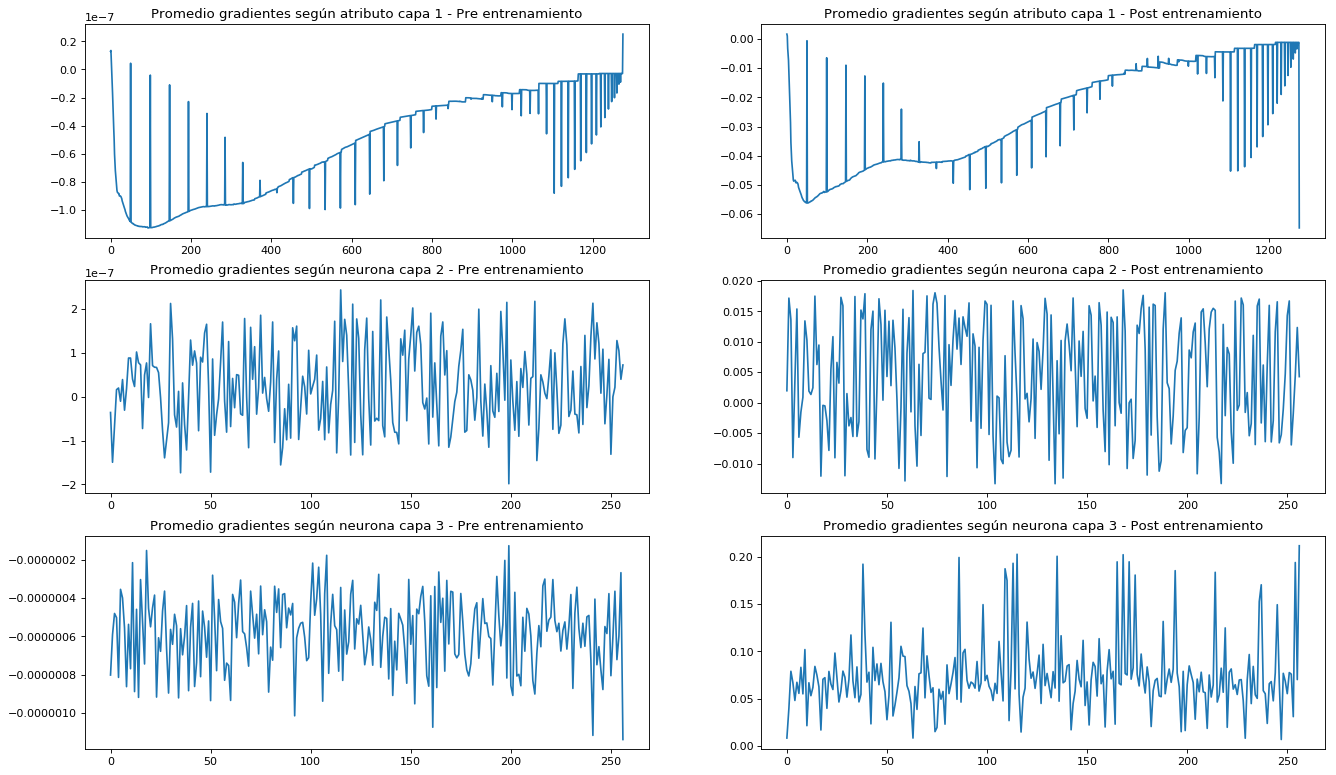

In [76]:
plt.pyplot.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,2,1)
plt.pyplot.title("Promedio gradientes según atributo capa 1 - Pre entrenamiento")
_ = plt.pyplot.plot(G_1_c_pre_mean)
plt.pyplot.subplot(3,2,2)
plt.pyplot.title("Promedio gradientes según atributo capa 1 - Post entrenamiento")
_ = plt.pyplot.plot(G_1_c_post_mean)
plt.pyplot.subplot(3,2,3)
plt.pyplot.title("Promedio gradientes según neurona capa 2 - Pre entrenamiento")
_ = plt.pyplot.plot(G_2_c_pre_mean)
plt.pyplot.subplot(3,2,4)
plt.pyplot.title("Promedio gradientes según neurona capa 2 - Post entrenamiento")
_ = plt.pyplot.plot(G_2_c_post_mean)
plt.pyplot.subplot(3,2,5)
plt.pyplot.title("Promedio gradientes según neurona capa 3 - Pre entrenamiento")
_ = plt.pyplot.plot(G_3_c_pre_mean)
plt.pyplot.subplot(3,2,6)
plt.pyplot.title("Promedio gradientes según neurona capa 3 - Post entrenamiento")
_ = plt.pyplot.plot(G_3_c_post_mean)

En general para las 2 y 3 se puede ver una disminución del promedio de sus gradientes por neurona, lo que puede indicar una actualización lenta de los pesos para las primeras capas.

#### Pesos

Ahora procedemos a hacer un análisis de los pesos, lo cual nos indicará como fue su actualización y también la importancia a ciertos atributos o neuronas.

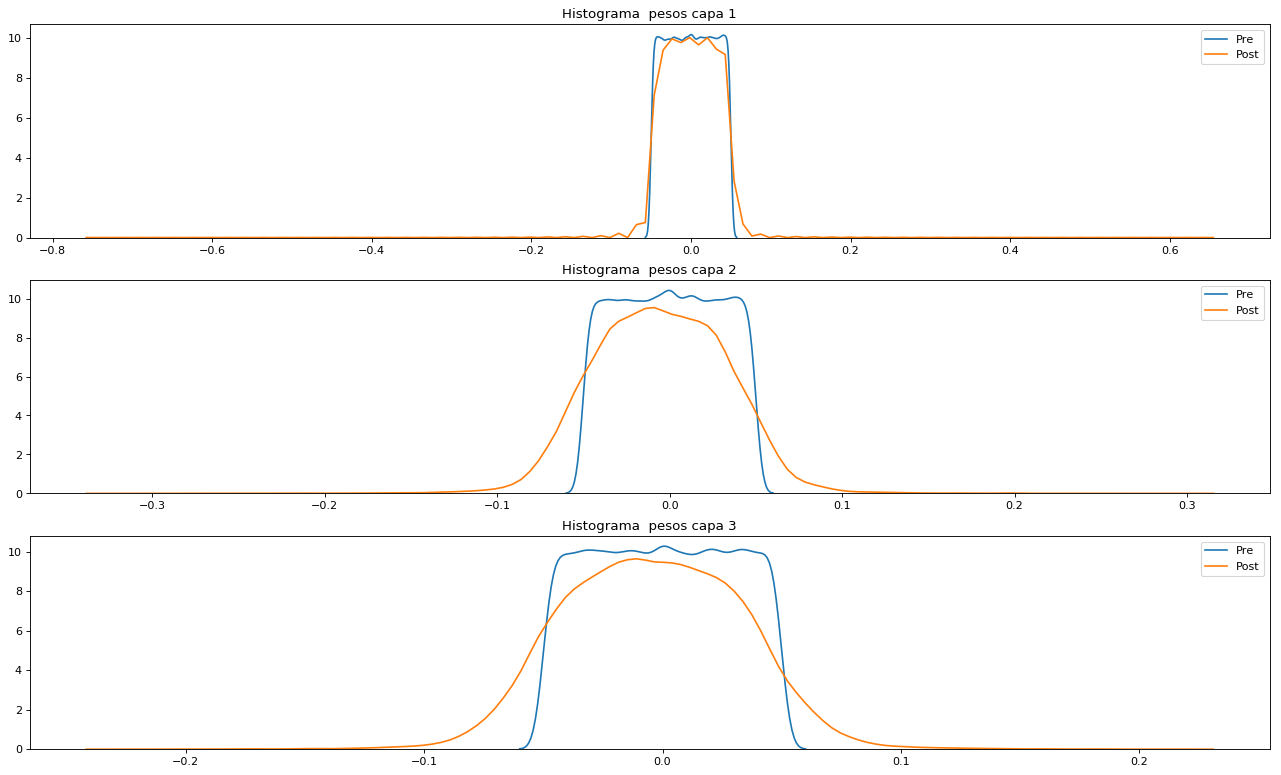

In [251]:
plt.pyplot.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,1,1)
plt.pyplot.title("Histograma  pesos capa 1")
flat_list = np.asarray(W_1_c_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_1_c_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(3,1,2)
plt.pyplot.title("Histograma  pesos capa 2")
flat_list = np.asarray(W_2_c_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_2_c_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(3,1,3)
plt.pyplot.title("Histograma  pesos capa 3")
flat_list = np.asarray(W_3_c_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_3_c_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")

Se puede ver parte del efecto del gradiente desvaneciente, es decir que va perdiendo su capacidad de actualizar pesos a medida que llega a las ultimas capas del Backpropagation.

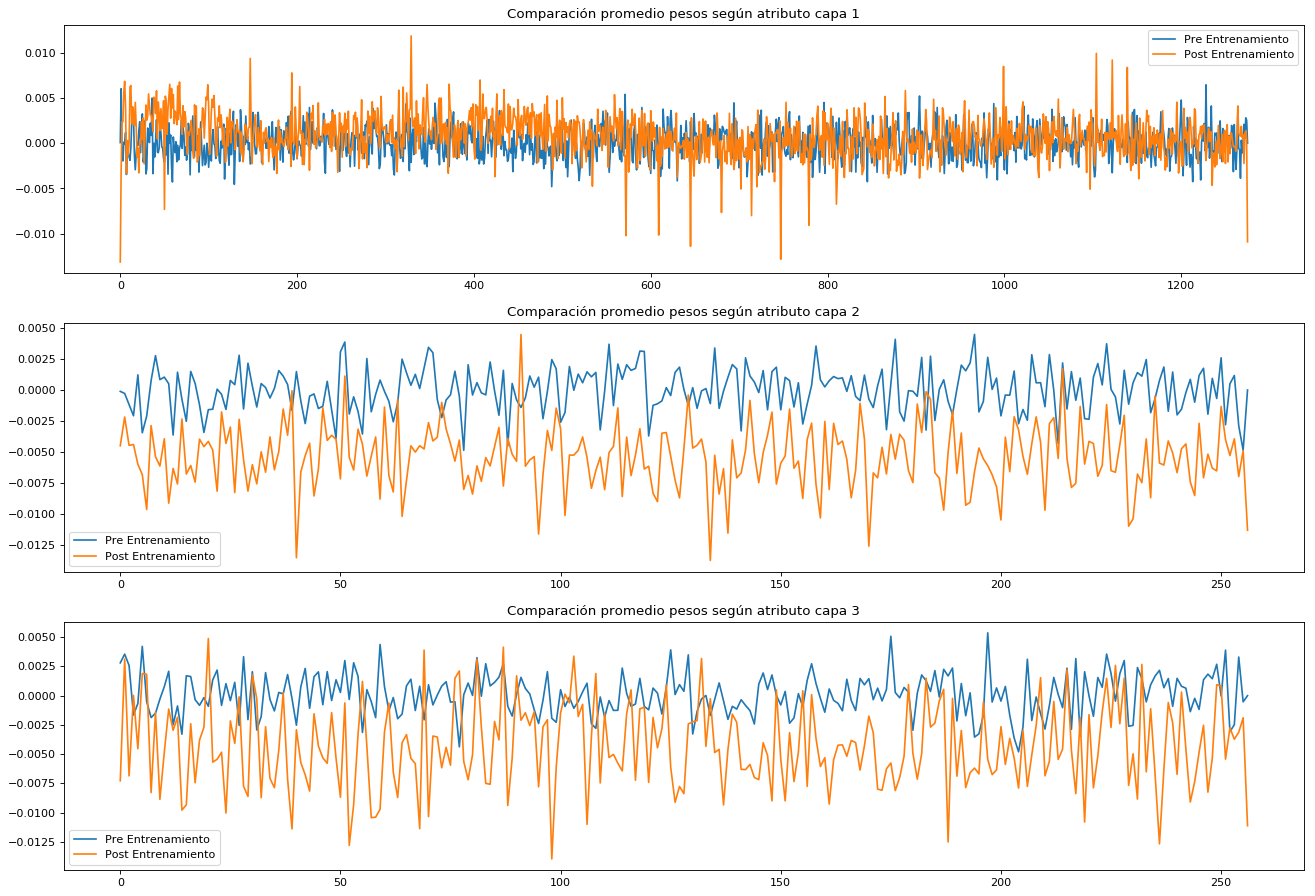

In [89]:
plt.pyplot.figure(figsize=(20, 14), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,1,1)
plt.pyplot.title("Comparación promedio pesos según atributo capa 1")
_ = plt.pyplot.plot(W_1_c_pre_mean, label='Pre Entrenamiento')
_ = plt.pyplot.plot(W_1_c_post_mean, label='Post Entrenamiento')
plt.pyplot.legend()
plt.pyplot.subplot(3,1,2)
plt.pyplot.title("Comparación promedio pesos según atributo capa 2")
_ = plt.pyplot.plot(W_2_c_pre_mean, label='Pre Entrenamiento')
_ = plt.pyplot.plot(W_2_c_post_mean, label='Post Entrenamiento')
plt.pyplot.legend()
plt.pyplot.subplot(3,1,3)
plt.pyplot.title("Comparación promedio pesos según atributo capa 3")
_ = plt.pyplot.plot(W_3_c_pre_mean, label='Pre Entrenamiento')
_ = plt.pyplot.plot(W_3_c_post_mean, label='Post Entrenamiento')
plt.pyplot.legend()

Como siempre se puede ver que el promedio de pesos para algunos atributos son más importantes que sus vecinos, aquí no es tan claro el defecto del gradiente.

### 2.d

Ahora se nos pide realizar el mismo procedimiento que en la red anterior, pero en este caso con el inicializador de Glorot y verificar si se amortigua el efecto del gradiente desvaneciente. Esto lo verificaremos por medio del calculo de la gradiente y pesos de las capas, para finalmente visualizar con el fin de obtener un análisis más cualitativo.

#### Pre Entrenamiento


In [91]:
model_2_d = Sequential()
model_2_d.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model_2_d.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model_2_d.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model_2_d.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model_2_d.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model_2_d.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model_2_d.compile(optimizer=sgd,loss='mean_squared_error')


 ###calculate gradients
loss_2_d_pre = keras.losses.mean_squared_error(model_2_d.output,y_train_scaled)
listOfVariableTensors_2_d_pre = model_2_d.trainable_weights 
gradients_2_d_pre = K.gradients(loss_2_d_pre, listOfVariableTensors_2_d_pre) #We can now calculate the gradients.
sess_2_d_pre = K.get_session()
evaluated_gradients_2_d_pre = sess_2_d_pre.run(gradients_2_d_pre,feed_dict={model_2_d.input:X_train_scaled.values})
evaluated_gradients_2_d_pre = [gradient/len(y_train) for gradient in evaluated_gradients_2_d_pre]


In [92]:
W_1_d_pre = np.concatenate((model_2_d.get_weights()[0],np.matrix(model_2_d.get_weights()[1])),axis=0)
W_1_d_pre_mean = np.mean((W_1_d_pre),axis=1)
W_2_d_pre = np.concatenate((model_2_d.get_weights()[2],np.matrix(model_2_d.get_weights()[3])),axis=0)
W_2_d_pre_mean = np.mean((W_2_d_pre),axis=1)
W_3_d_pre = np.concatenate((model_2_d.get_weights()[4],np.matrix(model_2_d.get_weights()[5])),axis=0)
W_3_d_pre_mean = np.mean((W_3_d_pre),axis=1)
G_1_d_pre = np.concatenate((evaluated_gradients_2_d_pre[0],np.matrix(evaluated_gradients_2_d_pre[1])),axis=0)
G_1_d_pre_mean = np.mean((G_1_d_pre),axis=1)
G_2_d_pre = np.concatenate((evaluated_gradients_2_d_pre[2],np.matrix(evaluated_gradients_2_d_pre[3])),axis=0)
G_2_d_pre_mean = np.mean((G_2_d_pre),axis=1)
G_3_d_pre = np.concatenate((evaluated_gradients_2_d_pre[4],np.matrix(evaluated_gradients_2_d_pre[5])),axis=0)
G_3_d_pre_mean = np.mean((G_3_d_pre),axis=1)

#### Post Training

In [93]:
history_2_d = model_2_d.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val))
model_2_d_json = model_2_d.to_json()
with open("modelos/model_2_d.json", "w") as json_file:
    json_file.write(model_2_d_json)
    model_2_d.save_weights("modelos/model_2_d.h5")   
    
###calculate gradients
loss_2_d_post = keras.losses.mean_squared_error(model_2_d.output,y_train_scaled)
listOfVariableTensors_2_d_post = model_2_d.trainable_weights 
gradients_2_d_post = K.gradients(loss_2_d_post, listOfVariableTensors_2_d_post) #We can now calculate the gradients.
sess_2_d_post = K.get_session()
evaluated_gradients_2_d_post = sess_2_d_post.run(gradients_2_d_post,feed_dict={model_2_d.input:X_train_scaled.values})
evaluated_gradients_2_d_post = [gradient/len(y_train) for gradient in evaluated_gradients_2_d_post]

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 273us/step - loss: 14.5874 - val_loss: 12.2866
Epoch 2/250
9745/9745 [==============================] - 2s 242us/step - loss: 4.0586 - val_loss: 1.0173
Epoch 3/250
9745/9745 [==============================] - 2s 244us/step - loss: 1.5848 - val_loss: 1.0143
Epoch 4/250
9745/9745 [==============================] - 2s 243us/step - loss: 1.0878 - val_loss: 1.0012
Epoch 5/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.9713 - val_loss: 0.6556
Epoch 6/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.7504 - val_loss: 0.5987
Epoch 7/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.6462 - val_loss: 0.3827
Epoch 8/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.6309 - val_loss: 0.4248
Epoch 9/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.4596 - val_loss: 0.5855
Epoch

Epoch 78/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0557 - val_loss: 0.0557
Epoch 79/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0481 - val_loss: 0.0490
Epoch 80/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0488 - val_loss: 0.0530
Epoch 81/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0565 - val_loss: 0.0529
Epoch 82/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0506 - val_loss: 0.0567
Epoch 83/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0478 - val_loss: 0.0471
Epoch 84/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0425 - val_loss: 0.0908
Epoch 85/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0472 - val_loss: 0.0683
Epoch 86/250
9745/9745 [==============================] - 2s 244us/step - loss: 0.0477 - val_loss: 0.0443
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 245us/step - loss: 0.0343 - val_loss: 0.0419
Epoch 156/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0273 - val_loss: 0.0348
Epoch 157/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0289 - val_loss: 0.0491
Epoch 158/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0315 - val_loss: 0.0492
Epoch 159/250
9745/9745 [==============================] - 2s 244us/step - loss: 0.0270 - val_loss: 0.0361
Epoch 160/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0298 - val_loss: 0.0462
Epoch 161/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0265 - val_loss: 0.0347
Epoch 162/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0341 - val_loss: 0.0894
Epoch 163/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0265 - val_loss: 0.0699
Epoch 164/250
9745/9745 [============

In [94]:
json_file = open('modelos/model_2_d.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2_d = model_from_json(loaded_model_json)
# load weights into new model
model_2_d.load_weights("modelos/model_2_d.h5")

Ahora se analizan los gradientes y pesos para las primeras 3 capas de la red, para poder verificar el efecto del gradiente desvaneciente y ver si en realidad se dejan de afectar los pesos en las capas iniciales.

In [95]:
W_1_d_post = np.concatenate((model_2_d.get_weights()[0],np.matrix(model_2_d.get_weights()[1])),axis=0)
W_1_d_post_mean = np.mean((W_1_d_post),axis=1)
W_2_d_post = np.concatenate((model_2_d.get_weights()[2],np.matrix(model_2_d.get_weights()[3])),axis=0)
W_2_d_post_mean = np.mean((W_2_d_post),axis=1)
W_3_d_post = np.concatenate((model_2_d.get_weights()[4],np.matrix(model_2_d.get_weights()[5])),axis=0)
W_3_d_post_mean = np.mean((W_3_d_post),axis=1)
G_1_d_post = np.concatenate((evaluated_gradients_2_d_post[0],np.matrix(evaluated_gradients_2_d_post[1])),axis=0)
G_1_d_post_mean = np.mean((G_1_d_post),axis=1)
G_2_d_post = np.concatenate((evaluated_gradients_2_d_post[2],np.matrix(evaluated_gradients_2_d_post[3])),axis=0)
G_2_d_post_mean = np.mean((G_2_d_post),axis=1)
G_3_d_post = np.concatenate((evaluated_gradients_2_d_post[4],np.matrix(evaluated_gradients_2_d_post[5])),axis=0)
G_3_d_post_mean = np.mean((G_3_d_post),axis=1)

#### Visualizaciones

Ahora con los gradientes y pesos de los modelos pre y post entrenamiento, podemos hacer una comparación de sus cambios respectivos. Y verificar que ocurre con el efecto del gradiente desvaneciente en este caso.

#####  Gradientes

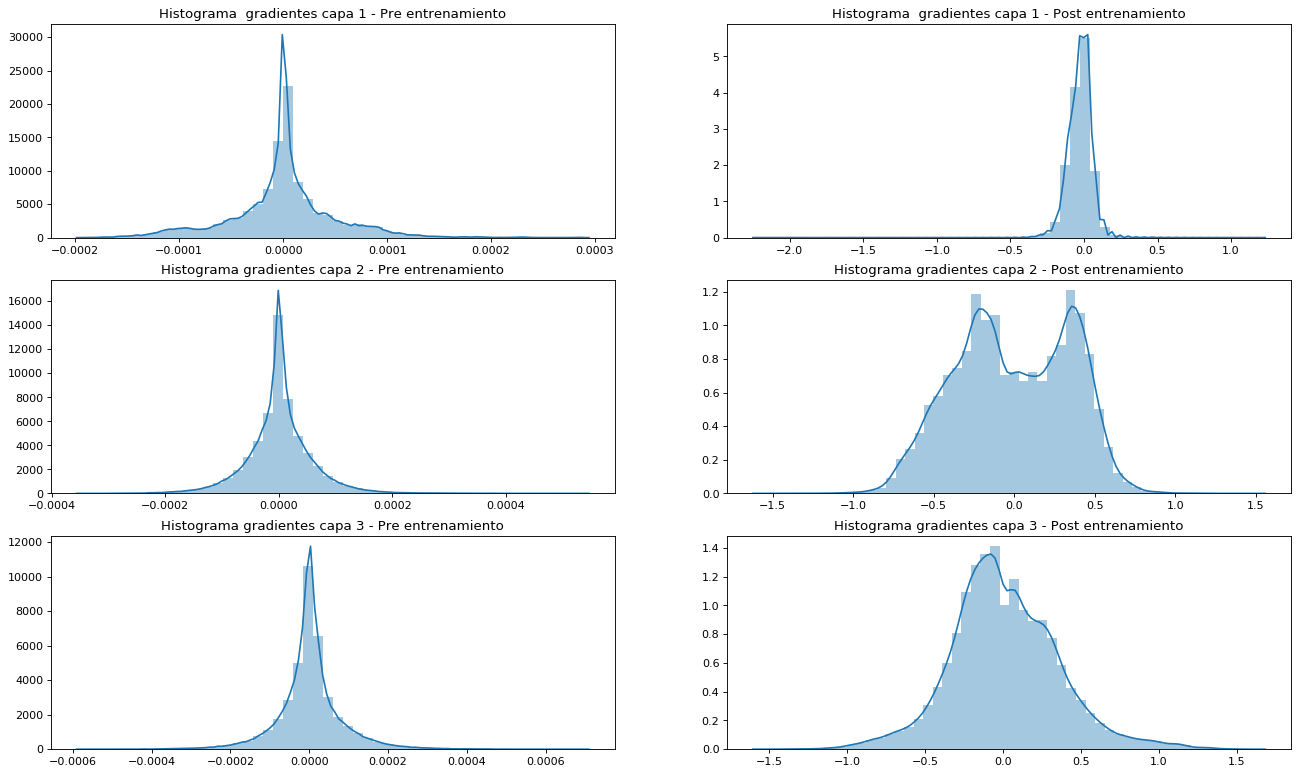

In [255]:
plt.pyplot.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,2,1)
plt.pyplot.title("Histograma  gradientes capa 1 - Pre entrenamiento")
flat_list = np.asarray(G_1_d_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,2)
plt.pyplot.title("Histograma  gradientes capa 1 - Post entrenamiento")
flat_list = np.asarray(G_1_d_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,3)
plt.pyplot.title("Histograma gradientes capa 2 - Pre entrenamiento")
flat_list = np.asarray(G_2_d_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,4)
plt.pyplot.title("Histograma gradientes capa 2 - Post entrenamiento")
flat_list = np.asarray(G_2_d_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,5)
plt.pyplot.title("Histograma gradientes capa 3 - Pre entrenamiento")
flat_list = np.asarray(G_3_d_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,2,6)
plt.pyplot.title("Histograma gradientes capa 3 - Post entrenamiento")
flat_list = np.asarray(G_3_d_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)

Como siempre tienden a dispersarse hacia los lados las distribuciones después del entrenamiento, sin embargo ahora en comparación al estudio del inciso c) podemos apreciar una mayor cantidad de gradientes igual a 0 en la distribución. 

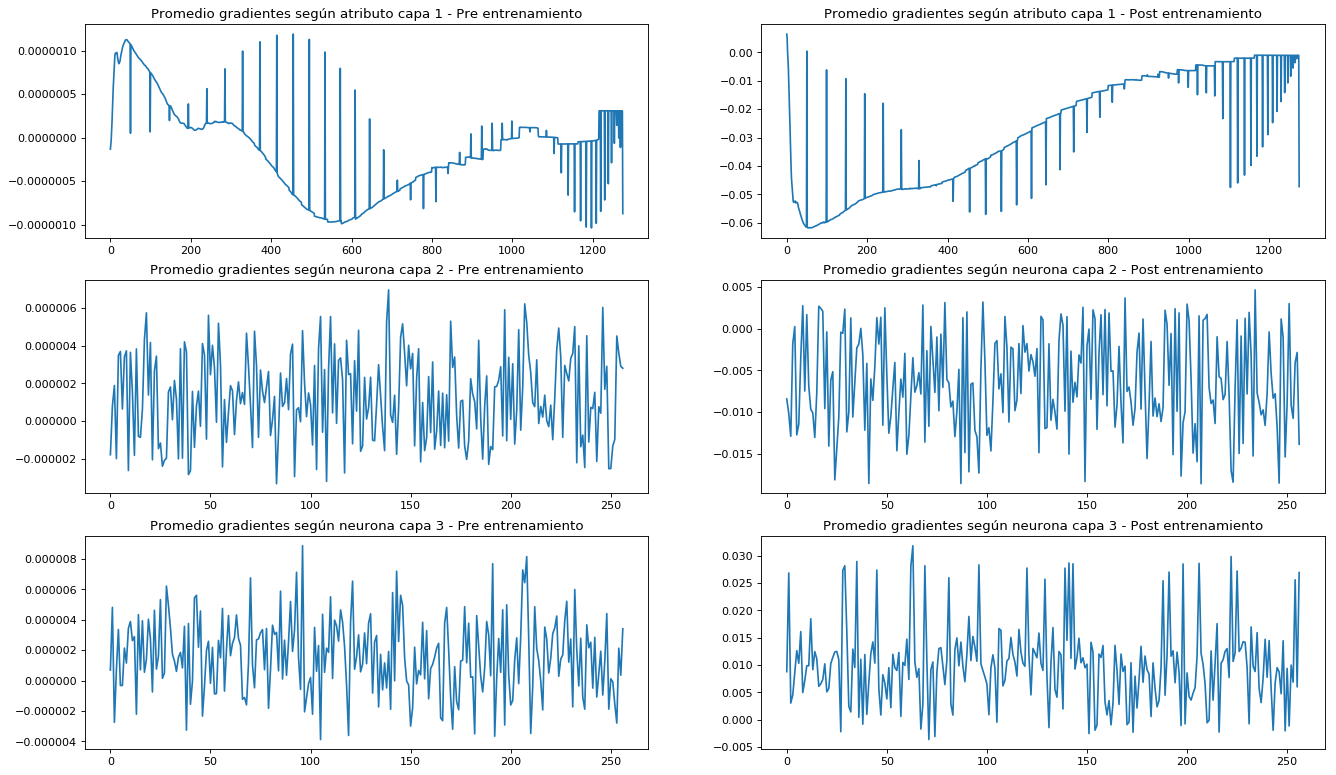

In [97]:
plt.pyplot.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,2,1)
plt.pyplot.title("Promedio gradientes según atributo capa 1 - Pre entrenamiento")
_ = plt.pyplot.plot(G_1_d_pre_mean)
plt.pyplot.subplot(3,2,2)
plt.pyplot.title("Promedio gradientes según atributo capa 1 - Post entrenamiento")
_ = plt.pyplot.plot(G_1_d_post_mean)
plt.pyplot.subplot(3,2,3)
plt.pyplot.title("Promedio gradientes según neurona capa 2 - Pre entrenamiento")
_ = plt.pyplot.plot(G_2_d_pre_mean)
plt.pyplot.subplot(3,2,4)
plt.pyplot.title("Promedio gradientes según neurona capa 2 - Post entrenamiento")
_ = plt.pyplot.plot(G_2_d_post_mean)
plt.pyplot.subplot(3,2,5)
plt.pyplot.title("Promedio gradientes según neurona capa 3 - Pre entrenamiento")
_ = plt.pyplot.plot(G_3_d_pre_mean)
plt.pyplot.subplot(3,2,6)
plt.pyplot.title("Promedio gradientes según neurona capa 3 - Post entrenamiento")
_ = plt.pyplot.plot(G_3_d_post_mean)

En general se puede ver que los promedios de gradientes después del entrenamiento se incrementan bastante, para el caso del Input se ve como siempre que algunos atributos sufrían cambios de sus pesos más drasticos.

#### Pesos

En esta sección se prestará especial importancia al fenomeno del gradiente desvaneciente, para poder comparar con los resultados de la red de la sección anterior.

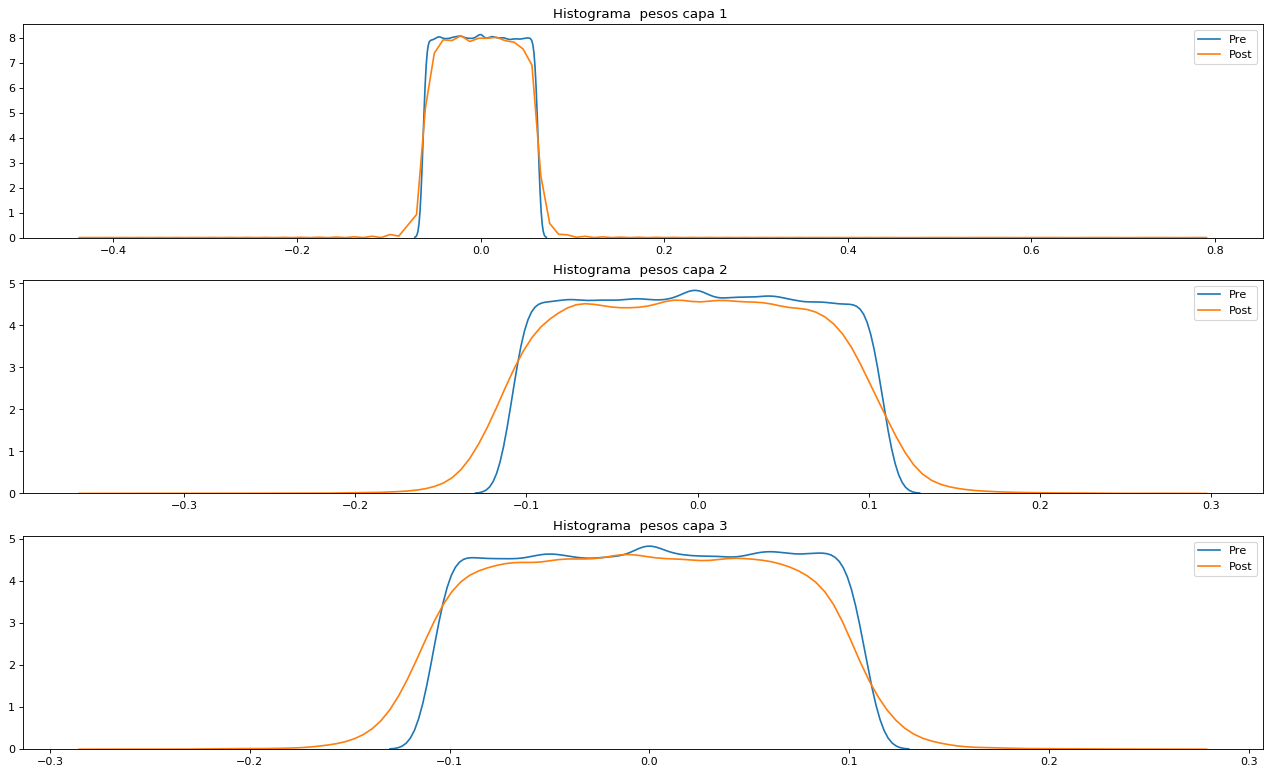

In [257]:
plt.pyplot.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,1,1)
plt.pyplot.title("Histograma  pesos capa 1 ")
flat_list = np.asarray(W_1_d_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_1_d_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(3,1,2)
plt.pyplot.title("Histograma  pesos capa 2 ")
flat_list = np.asarray(W_2_d_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_2_d_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(3,1,3)
plt.pyplot.title("Histograma  pesos capa 3 ")
flat_list = np.asarray(W_3_d_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False, label="Pre")
flat_list = np.asarray(W_3_d_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")

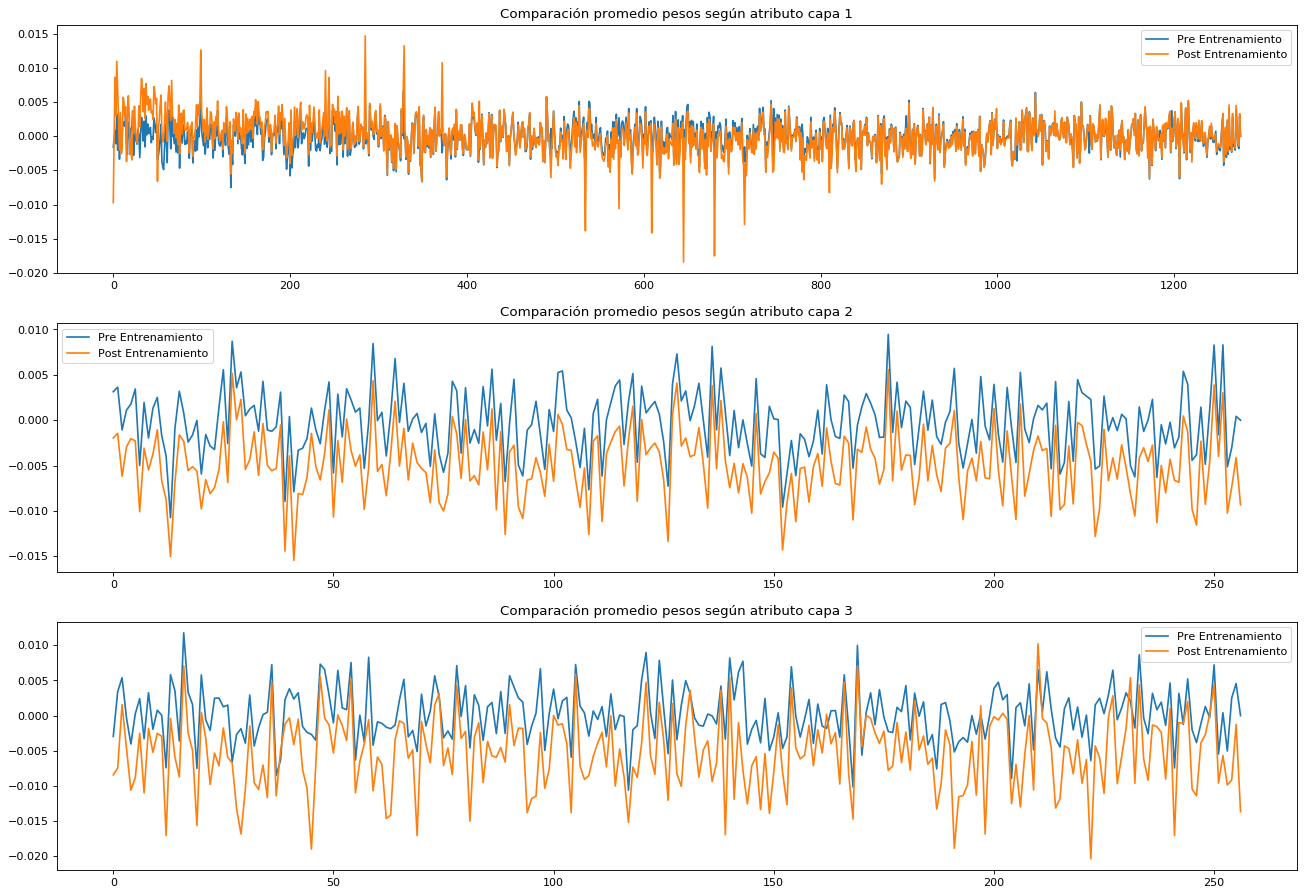

In [99]:
plt.pyplot.figure(figsize=(20, 14), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,1,1)
plt.pyplot.title("Comparación promedio pesos según atributo capa 1")
_ = plt.pyplot.plot(W_1_d_pre_mean, label='Pre Entrenamiento')
_ = plt.pyplot.plot(W_1_d_post_mean, label='Post Entrenamiento')
plt.pyplot.legend()
plt.pyplot.subplot(3,1,2)
plt.pyplot.title("Comparación promedio pesos según atributo capa 2")
_ = plt.pyplot.plot(W_2_d_pre_mean, label='Pre Entrenamiento')
_ = plt.pyplot.plot(W_2_d_post_mean, label='Post Entrenamiento')
plt.pyplot.legend()
plt.pyplot.subplot(3,1,3)
plt.pyplot.title("Comparación promedio pesos según atributo capa 3")
_ = plt.pyplot.plot(W_3_d_pre_mean, label='Pre Entrenamiento')
_ = plt.pyplot.plot(W_3_d_post_mean, label='Post Entrenamiento')
plt.pyplot.legend()

Se puede apreciar que los valores previos y post al entrenamiento son similares para los pesos, tanto en su promedio por neurona como en su frecuencia. Sin embargo, los valores de los gradientes no son pequeños pero el cambio de pesos no es tan notorio como en la sección anterior. Es decir es posible que se amortigue el efecto del gradiente desvaneciente, pero se debería analizar más capas para asegurarse de que los cambios sean similares en la red, es decir que no este ocurriendo previamente el desvanecimiento del gradiente.

### 2.e  Red profunda ReLU

Ahora debemos cambiar la función de activación Sigmoid, por ReLU. Primero iniciaremos la red profunda con distribución uniforme, sin embargo también probaremos con *He-uniform*. Debemos analizar si se provoca de igual manera el efecto del gradiente desvaneciente a pesar de cambiar la función de activación. Por lo que procederemos a calcular gradientes y pesos para cada caso antes de empezar a visualizar.

#### Pre Entrenamiento

#### 1. Uniform

In [261]:
model_2_e_1 = Sequential()
model_2_e_1.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model_2_e_1.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model_2_e_1.add(Dense(256,  kernel_initializer='uniform',activation='relu'))
model_2_e_1.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model_2_e_1.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model_2_e_1.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.001)
model_2_e_1.compile(optimizer=sgd,loss='mean_squared_error')


 ###calculate gradients
loss_2_e_1_pre = keras.losses.mean_squared_error(model_2_e_1.output,y_train_scaled)
listOfVariableTensors_2_e_1_pre = model_2_e_1.trainable_weights 
gradients_2_e_1_pre = K.gradients(loss_2_e_1_pre, listOfVariableTensors_2_e_1_pre) #We can now calculate the gradients.
sess_2_e_1_pre = K.get_session()
evaluated_gradients_2_e_1_pre = sess_2_e_1_pre.run(gradients_2_e_1_pre,feed_dict={model_2_e_1.input:X_train_scaled.values})
evaluated_gradients_2_e_1_pre = [gradient/len(y_train) for gradient in evaluated_gradients_2_e_1_pre]

In [262]:
W_1_e_1_pre = np.concatenate((model_2_e_1.get_weights()[0],np.matrix(model_2_e_1.get_weights()[1])),axis=0)
W_1_e_1_pre_mean = np.mean((W_1_e_1_pre),axis=1)
W_2_e_1_pre = np.concatenate((model_2_e_1.get_weights()[2],np.matrix(model_2_e_1.get_weights()[3])),axis=0)
W_2_e_1_pre_mean = np.mean((W_2_e_1_pre),axis=1)
W_3_e_1_pre = np.concatenate((model_2_e_1.get_weights()[4],np.matrix(model_2_e_1.get_weights()[5])),axis=0)
W_3_e_1_pre_mean = np.mean((W_3_e_1_pre),axis=1)
G_1_e_1_pre = np.concatenate((evaluated_gradients_2_e_1_pre[0],np.matrix(evaluated_gradients_2_e_1_pre[1])),axis=0)
G_1_e_1_pre_mean = np.mean((G_1_e_1_pre),axis=1)
G_2_e_1_pre = np.concatenate((evaluated_gradients_2_e_1_pre[2],np.matrix(evaluated_gradients_2_e_1_pre[3])),axis=0)
G_2_e_1_pre_mean = np.mean((G_2_e_1_pre),axis=1)
G_3_e_1_pre = np.concatenate((evaluated_gradients_2_e_1_pre[4],np.matrix(evaluated_gradients_2_e_1_pre[5])),axis=0)
G_3_e_1_pre_mean = np.mean((G_3_e_1_pre),axis=1)

#### Post Training

In [263]:
history_2_e_1 = model_2_e_1.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val),callbacks=[keras.callbacks.TerminateOnNaN()])
model_2_e_1_json = model_2_e_1.to_json()
with open("modelos/model_2_e_1.json", "w") as json_file:
    json_file.write(model_2_e_1_json)
    model_2_e_1.save_weights("modelos/model_2_e_1.h5") 


 ###calculate gradients
loss_2_e_1_post = keras.losses.mean_squared_error(model_2_e_1.output,y_train_scaled)
listOfVariableTensors_2_e_1_post = model_2_e_1.trainable_weights 
gradients_2_e_1_post = K.gradients(loss_2_e_1_post, listOfVariableTensors_2_e_1_post) #We can now calculate the gradients.
sess_2_e_1_post = K.get_session()
evaluated_gradients_2_e_1_post = sess_2_e_1_post.run(gradients_2_e_1_post,feed_dict={model_2_e_1.input:X_train_scaled.values})
evaluated_gradients_2_e_1_post = [gradient/len(y_train) for gradient in evaluated_gradients_2_e_1_post]

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 328us/step - loss: 28.7651 - val_loss: 2.1636
Epoch 2/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.8782 - val_loss: 1.6848
Epoch 3/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.5016 - val_loss: 1.3188
Epoch 4/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.3582 - val_loss: 0.7908
Epoch 5/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.2906 - val_loss: 0.9624
Epoch 6/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.3416 - val_loss: 0.7531
Epoch 7/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.2312 - val_loss: 0.6428
Epoch 8/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.2004 - val_loss: 0.5937
Epoch 9/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.1720 - val_loss: 0.5981
Epoch 

Epoch 78/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0341 - val_loss: 0.2220
Epoch 79/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0344 - val_loss: 0.2413
Epoch 80/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0346 - val_loss: 0.2275
Epoch 81/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0352 - val_loss: 0.2468
Epoch 82/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0354 - val_loss: 0.1975
Epoch 83/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0344 - val_loss: 0.2010
Epoch 84/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0337 - val_loss: 0.1954
Epoch 85/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0318 - val_loss: 0.2000
Epoch 86/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0336 - val_loss: 0.2256
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0201 - val_loss: 0.1960
Epoch 156/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0191 - val_loss: 0.2250
Epoch 157/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0203 - val_loss: 0.1926
Epoch 158/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0215 - val_loss: 0.2011
Epoch 159/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0208 - val_loss: 0.1901
Epoch 160/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0203 - val_loss: 0.1944
Epoch 161/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0191 - val_loss: 0.1897
Epoch 162/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0188 - val_loss: 0.2119
Epoch 163/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0222 - val_loss: 0.1996
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 2s 251us/step - loss: 0.0156 - val_loss: 0.1890
Epoch 232/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0155 - val_loss: 0.1971
Epoch 233/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0158 - val_loss: 0.1911
Epoch 234/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0160 - val_loss: 0.1994
Epoch 235/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0155 - val_loss: 0.1874
Epoch 236/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0165 - val_loss: 0.1936
Epoch 237/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0156 - val_loss: 0.1981
Epoch 238/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0150 - val_loss: 0.1948
Epoch 239/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0151 - val_loss: 0.1965
Epoch 240/250
9745/9745 [==========================

In [264]:
json_file = open('modelos/model_2_e_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2_e_1 = model_from_json(loaded_model_json)
# load weights into new model
model_2_e_1.load_weights("modelos/model_2_e_1.h5")

In [265]:
W_1_e_1_post = np.concatenate((model_2_e_1.get_weights()[0],np.matrix(model_2_e_1.get_weights()[1])),axis=0)
W_1_e_1_post_mean = np.mean((W_1_e_1_post),axis=1)
W_2_e_1_post = np.concatenate((model_2_e_1.get_weights()[2],np.matrix(model_2_e_1.get_weights()[3])),axis=0)
W_2_e_1_post_mean = np.mean((W_2_e_1_post),axis=1)
W_3_e_1_post = np.concatenate((model_2_e_1.get_weights()[4],np.matrix(model_2_e_1.get_weights()[5])),axis=0)
W_3_e_1_post_mean = np.mean((W_3_e_1_post),axis=1)
G_1_e_1_post = np.concatenate((evaluated_gradients_2_e_1_post[0],np.matrix(evaluated_gradients_2_e_1_post[1])),axis=0)
G_1_e_1_post_mean = np.mean((G_1_e_1_post),axis=1)
G_2_e_1_post = np.concatenate((evaluated_gradients_2_e_1_post[2],np.matrix(evaluated_gradients_2_e_1_post[3])),axis=0)
G_2_e_1_post_mean = np.mean((G_2_e_1_post),axis=1)
G_3_e_1_post = np.concatenate((evaluated_gradients_2_e_1_post[4],np.matrix(evaluated_gradients_2_e_1_post[5])),axis=0)
G_3_e_1_post_mean = np.mean((G_3_e_1_post),axis=1)

#### 2. He-uniform

In [147]:
model_2_e_2 = Sequential()
model_2_e_2.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model_2_e_2.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model_2_e_2.add(Dense(256,  kernel_initializer='he_uniform',activation='relu'))
model_2_e_2.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model_2_e_2.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model_2_e_2.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
sgd = SGD(lr=0.001)
model_2_e_2.compile(optimizer=sgd,loss='mean_squared_error')


 ###calculate gradients
loss_2_e_2_pre = keras.losses.mean_squared_error(model_2_e_2.output,y_train_scaled)
listOfVariableTensors_2_e_2_pre = model_2_e_2.trainable_weights 
gradients_2_e_2_pre = K.gradients(loss_2_e_2_pre, listOfVariableTensors_2_e_2_pre) #We can now calculate the gradients.
sess_2_e_2_pre = K.get_session()
evaluated_gradients_2_e_2_pre = sess_2_e_2_pre.run(gradients_2_e_2_pre,feed_dict={model_2_e_2.input:X_train_scaled.values})
evaluated_gradients_2_e_2_pre = [gradient/len(y_train) for gradient in evaluated_gradients_2_e_2_pre]

In [148]:
W_1_e_2_pre = np.concatenate((model_2_e_2.get_weights()[0],np.matrix(model_2_e_2.get_weights()[1])),axis=0)
W_1_e_2_pre_mean = np.mean((W_1_e_2_pre),axis=1)
W_2_e_2_pre = np.concatenate((model_2_e_2.get_weights()[2],np.matrix(model_2_e_2.get_weights()[3])),axis=0)
W_2_e_2_pre_mean = np.mean((W_2_e_2_pre),axis=1)
W_3_e_2_pre = np.concatenate((model_2_e_2.get_weights()[4],np.matrix(model_2_e_2.get_weights()[5])),axis=0)
W_3_e_2_pre_mean = np.mean((W_3_e_2_pre),axis=1)
G_1_e_2_pre = np.concatenate((evaluated_gradients_2_e_2_pre[0],np.matrix(evaluated_gradients_2_e_2_pre[1])),axis=0)
G_1_e_2_pre_mean = np.mean((G_1_e_2_pre),axis=1)
G_2_e_2_pre = np.concatenate((evaluated_gradients_2_e_2_pre[2],np.matrix(evaluated_gradients_2_e_2_pre[3])),axis=0)
G_2_e_2_pre_mean = np.mean((G_2_e_2_pre),axis=1)
G_3_e_2_pre = np.concatenate((evaluated_gradients_2_e_2_pre[4],np.matrix(evaluated_gradients_2_e_2_pre[5])),axis=0)
G_3_e_2_pre_mean = np.mean((G_3_e_2_pre),axis=1)

#### Post Training

In [149]:
history_2_e_2 = model_2_e_2.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val),callbacks=[keras.callbacks.TerminateOnNaN()])
model_2_e_2_json = model_2_e_2.to_json()
with open("modelos/model_2_e_2.json", "w") as json_file:
    json_file.write(model_2_e_2_json)
    model_2_e_2.save_weights("modelos/model_2_e_2.h5") 


 ###calculate gradients
loss_2_e_2_post = keras.losses.mean_squared_error(model_2_e_2.output,y_train_scaled)
listOfVariableTensors_2_e_2_post = model_2_e_2.trainable_weights 
gradients_2_e_2_post = K.gradients(loss_2_e_2_post, listOfVariableTensors_2_e_2_post) #We can now calculate the gradients.
sess_2_e_2_post = K.get_session()
evaluated_gradients_2_e_2_post = sess_2_e_2_post.run(gradients_2_e_2_post,feed_dict={model_2_e_2.input:X_train_scaled.values})
evaluated_gradients_2_e_2_post = [gradient/len(y_train) for gradient in evaluated_gradients_2_e_2_post]

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 323us/step - loss: 15.6437 - val_loss: 3.4839
Epoch 2/250
9745/9745 [==============================] - 2s 252us/step - loss: 3.5767 - val_loss: 7.5271
Epoch 3/250
9745/9745 [==============================] - 3s 258us/step - loss: 1.9822 - val_loss: 2.1666
Epoch 4/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.6368 - val_loss: 1.6143
Epoch 5/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.9552 - val_loss: 1.0934
Epoch 6/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.4380 - val_loss: 1.7040
Epoch 7/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.3914 - val_loss: 0.8099
Epoch 8/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.2476 - val_loss: 0.8253
Epoch 9/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.2340 - val_loss: 0.9446
Epoch 

Epoch 78/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0312 - val_loss: 0.3067
Epoch 79/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0321 - val_loss: 0.3444
Epoch 80/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.0319 - val_loss: 0.2473
Epoch 81/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0299 - val_loss: 0.2951
Epoch 82/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0324 - val_loss: 0.2974
Epoch 83/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0343 - val_loss: 0.2919
Epoch 84/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0382 - val_loss: 0.2754
Epoch 85/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0278 - val_loss: 0.2594
Epoch 86/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0275 - val_loss: 0.2581
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0168 - val_loss: 0.2291
Epoch 156/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0187 - val_loss: 0.2267
Epoch 157/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.0206 - val_loss: 0.2399
Epoch 158/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0171 - val_loss: 0.2336
Epoch 159/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0194 - val_loss: 0.2458
Epoch 160/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0183 - val_loss: 0.2328
Epoch 161/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0207 - val_loss: 0.2262
Epoch 162/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0200 - val_loss: 0.2296
Epoch 163/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0163 - val_loss: 0.2343
Epoch 164/250
9745/9745 [============

In [150]:
json_file = open('modelos/model_2_e_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2_e_2 = model_from_json(loaded_model_json)
# load weights into new model
model_2_e_2.load_weights("modelos/model_2_e_2.h5")

In [151]:
W_1_e_2_post = np.concatenate((model_2_e_2.get_weights()[0],np.matrix(model_2_e_2.get_weights()[1])),axis=0)
W_1_e_2_post_mean = np.mean((W_1_e_2_post),axis=1)
W_2_e_2_post = np.concatenate((model_2_e_2.get_weights()[2],np.matrix(model_2_e_2.get_weights()[3])),axis=0)
W_2_e_2_post_mean = np.mean((W_2_e_2_post),axis=1)
W_3_e_2_post = np.concatenate((model_2_e_2.get_weights()[4],np.matrix(model_2_e_2.get_weights()[5])),axis=0)
W_3_e_2_post_mean = np.mean((W_3_e_2_post),axis=1)
G_1_e_2_post = np.concatenate((evaluated_gradients_2_e_2_post[0],np.matrix(evaluated_gradients_2_e_2_post[1])),axis=0)
G_1_e_2_post_mean = np.mean((G_1_e_2_post),axis=1)
G_2_e_2_post = np.concatenate((evaluated_gradients_2_e_2_post[2],np.matrix(evaluated_gradients_2_e_2_post[3])),axis=0)
G_2_e_2_post_mean = np.mean((G_2_e_2_post),axis=1)
G_3_e_2_post = np.concatenate((evaluated_gradients_2_e_2_post[4],np.matrix(evaluated_gradients_2_e_2_post[5])),axis=0)
G_3_e_2_post_mean = np.mean((G_3_e_2_post),axis=1)

#### Visualizaciones para 2.e.1 (Uniform) y 2.e.2 (He-uniform)

Ahora con los gradientes y pesos de los modelos pre y post entrenamiento, podemos hacer una comparación de sus cambios respectivos. Según capa y tipo de inicialización.

#####  Gradientes

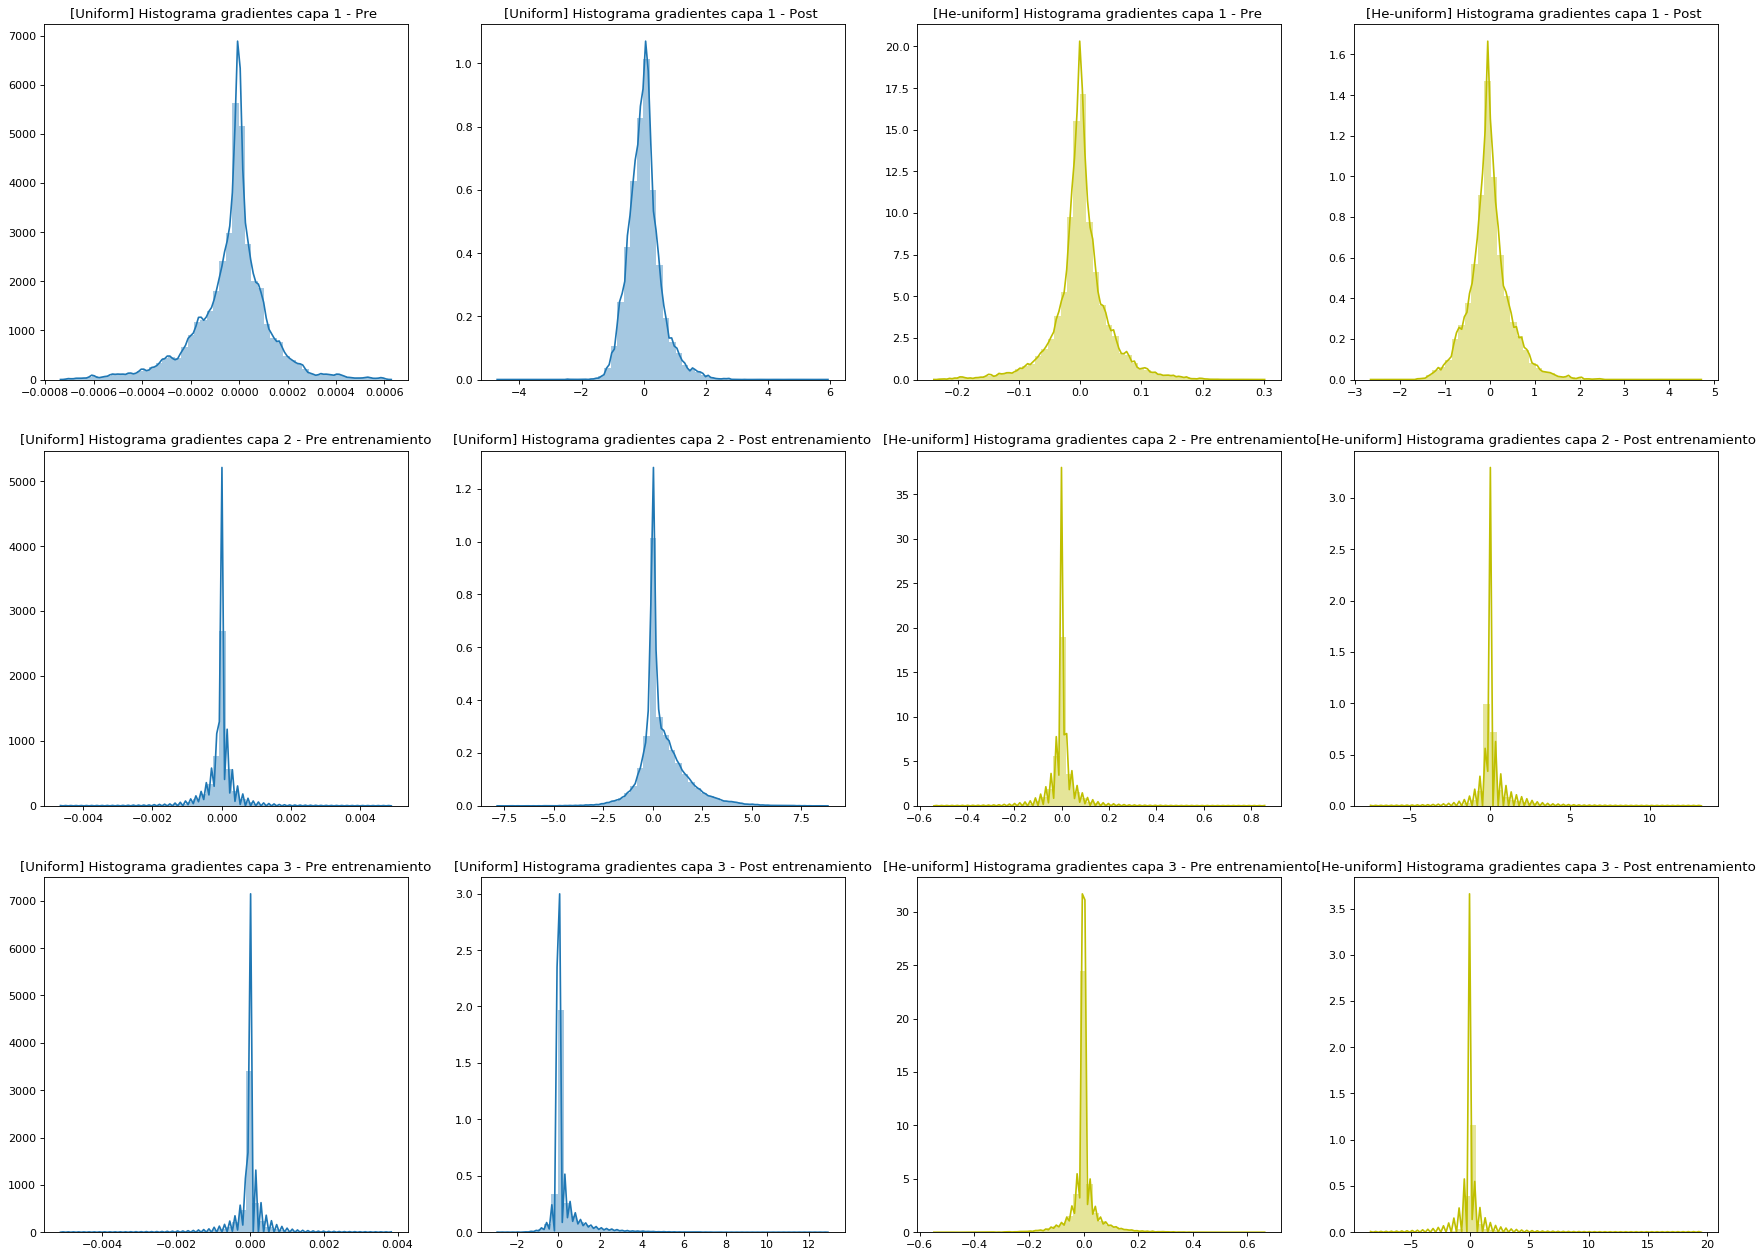

In [266]:
plt.pyplot.figure(figsize=(27, 20), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,4,1)
plt.pyplot.title("[Uniform] Histograma gradientes capa 1 - Pre ")
flat_list = np.asarray(G_1_e_1_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,4,2)
plt.pyplot.title("[Uniform] Histograma gradientes capa 1 - Post ")
flat_list = np.asarray(G_1_e_1_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,4,3)
plt.pyplot.title("[He-uniform] Histograma gradientes capa 1 - Pre ")
flat_list = np.asarray(G_1_e_2_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True,color='y')
plt.pyplot.subplot(3,4,4)
plt.pyplot.title("[He-uniform] Histograma gradientes capa 1 - Post ")
flat_list = np.asarray(G_1_e_2_post.flatten())
sns.distplot(flat_list,rug=False, hist=True,color='y')


plt.pyplot.subplot(3,4,5)
plt.pyplot.title("[Uniform] Histograma gradientes capa 2 - Pre entrenamiento")
flat_list = np.asarray(G_2_e_1_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,4,6)
plt.pyplot.title("[Uniform] Histograma gradientes capa 2 - Post entrenamiento")
flat_list = np.asarray(G_2_e_1_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,4,7)
plt.pyplot.title("[He-uniform] Histograma gradientes capa 2 - Pre entrenamiento")
flat_list = np.asarray(G_2_e_2_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True,color='y')
plt.pyplot.subplot(3,4,8)
plt.pyplot.title("[He-uniform] Histograma gradientes capa 2 - Post entrenamiento")
flat_list = np.asarray(G_2_e_2_post.flatten())
sns.distplot(flat_list,rug=False, hist=True,color='y')


plt.pyplot.subplot(3,4,9)
plt.pyplot.title("[Uniform] Histograma gradientes capa 3 - Pre entrenamiento")
flat_list = np.asarray(G_3_e_1_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,4,10)
plt.pyplot.title("[Uniform] Histograma gradientes capa 3 - Post entrenamiento")
flat_list = np.asarray(G_3_e_1_post.flatten())
sns.distplot(flat_list,rug=False, hist=True)
plt.pyplot.subplot(3,4,11)
plt.pyplot.title("[He-uniform] Histograma gradientes capa 3 - Pre entrenamiento")
flat_list = np.asarray(G_3_e_2_pre.flatten())
sns.distplot(flat_list,rug=False, hist=True,color='y')
plt.pyplot.subplot(3,4,12)
plt.pyplot.title("[He-uniform] Histograma gradientes capa 3 - Post entrenamiento")
flat_list = np.asarray(G_3_e_2_post.flatten())
sns.distplot(flat_list,rug=False, hist=True,color='y')

Se puede notar que la inicialización del tipo 'He-uniform' permite llegar a una distribución mas amplia de valores para los gradientes de los pesos. 

#### Pesos

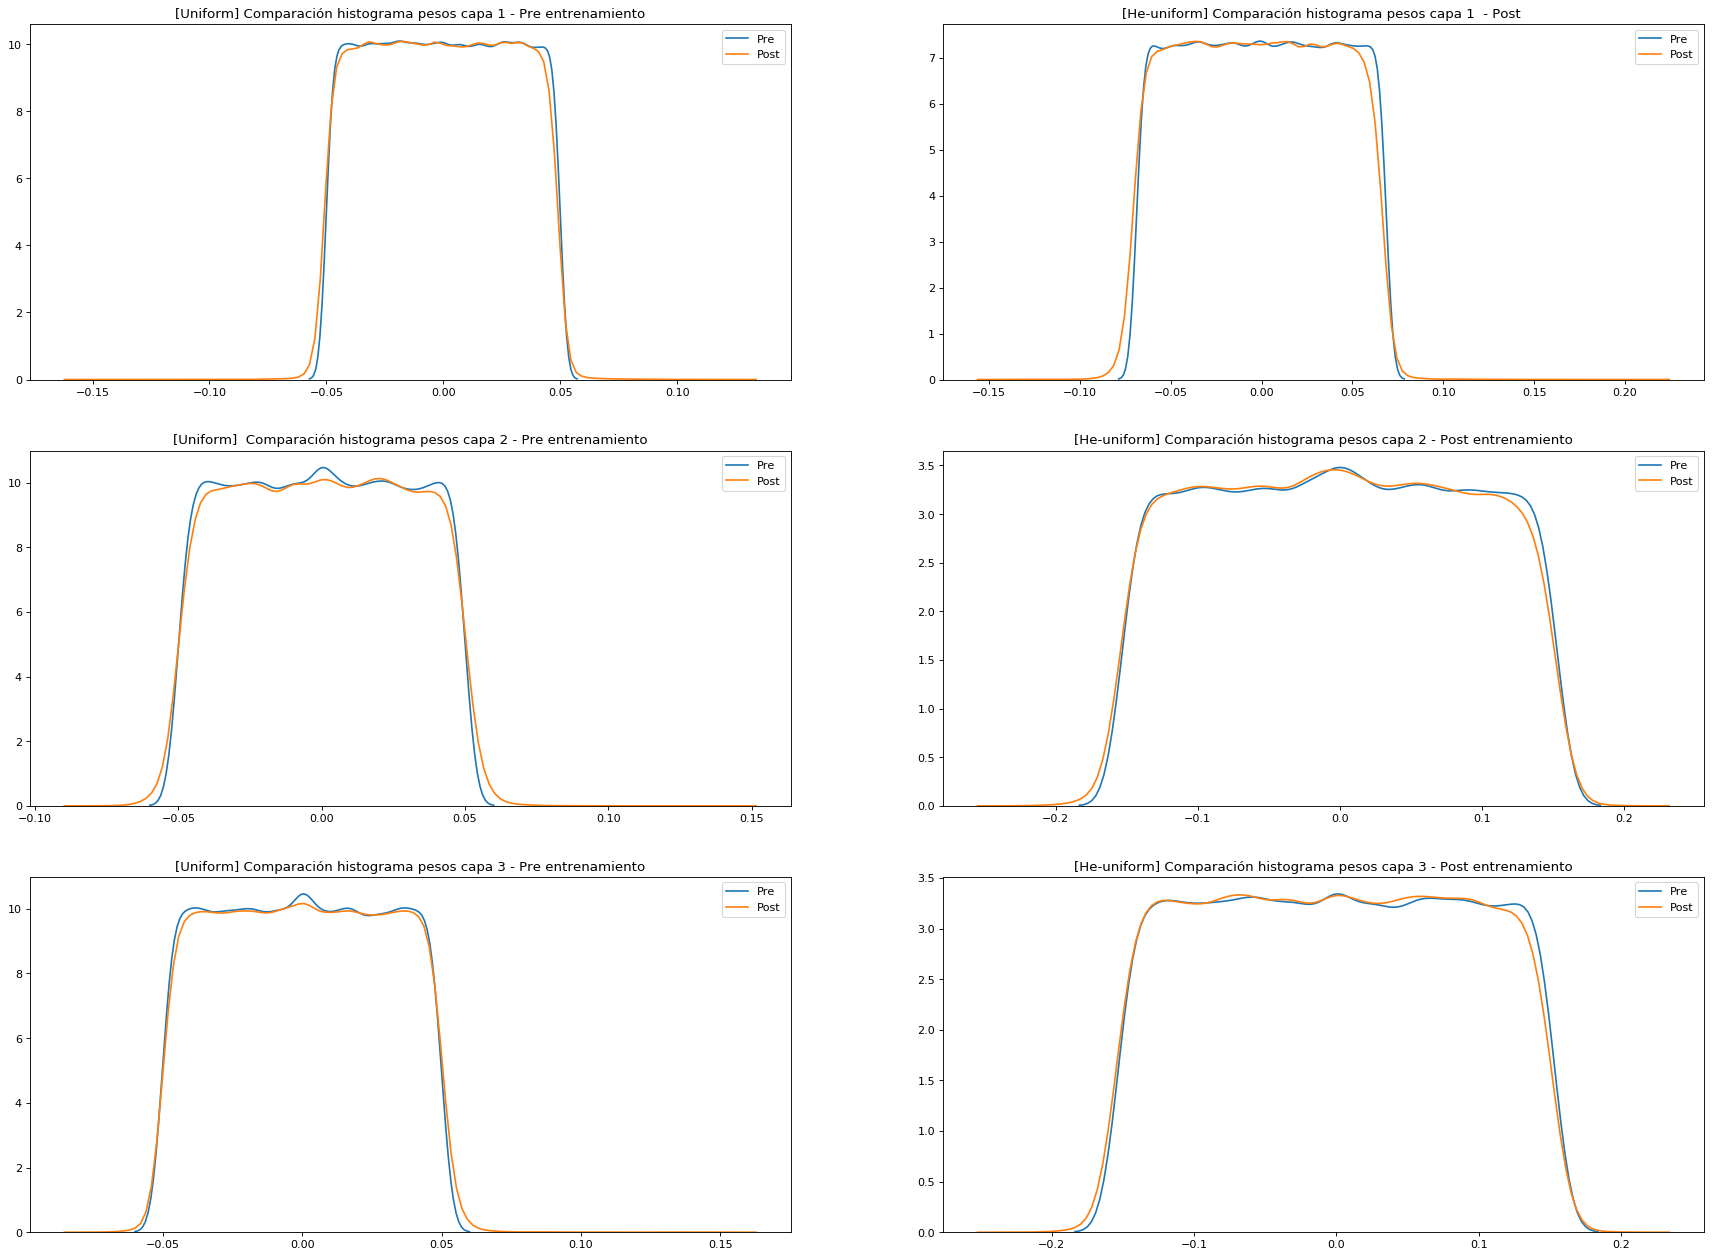

In [267]:
plt.pyplot.figure(figsize=(27, 20), dpi=80, facecolor='w', edgecolor='b')
plt.pyplot.subplot(3,2,1)
plt.pyplot.title("[Uniform] Comparación histograma pesos capa 1 - Pre entrenamiento")
flat_list = np.asarray(W_1_e_1_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Pre")
flat_list = np.asarray(W_1_e_1_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(3,2,2)
plt.pyplot.title("[He-uniform] Comparación histograma pesos capa 1  - Post ")
flat_list = np.asarray(W_1_e_2_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Pre")
flat_list = np.asarray(W_1_e_2_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")

plt.pyplot.subplot(3,2,3)
plt.pyplot.title("[Uniform]  Comparación histograma pesos capa 2 - Pre entrenamiento")
flat_list = np.asarray(W_2_e_1_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Pre")
flat_list = np.asarray(W_2_e_1_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(3,2,4)
plt.pyplot.title("[He-uniform] Comparación histograma pesos capa 2 - Post entrenamiento")
flat_list = np.asarray(W_2_e_2_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Pre")
flat_list = np.asarray(W_2_e_2_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")

plt.pyplot.subplot(3,2,5)
plt.pyplot.title("[Uniform] Comparación histograma pesos capa 3 - Pre entrenamiento")
flat_list = np.asarray(W_3_e_1_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Pre")
flat_list = np.asarray(W_3_e_1_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")
plt.pyplot.subplot(3,2,6)
plt.pyplot.title("[He-uniform] Comparación histograma pesos capa 3 - Post entrenamiento")
flat_list = np.asarray(W_3_e_2_pre.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Pre")
flat_list = np.asarray(W_3_e_2_post.flatten())
sns.distplot(flat_list,rug=False, hist=False,label="Post")


Notamos que con las 2 inicializaciones los histogramas no varían demasiado. La importancia principal respecto a como se inicializan los pesos recae en evitar caer en el problema del gradiente desvaneciente, sin embargo notamos que para redes profundas una selección de distribución uniforme puede provocar este problema, comoo se vio en el inciso c) dado que para la red profunda la variación de pesos iba disminuyendo a medida que se acercaban a las primeras capas.

(-1, 7)

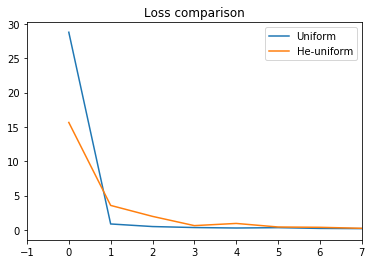

In [289]:
plt.pyplot.title("Loss comparison")
plt.pyplot.plot(history_2_e_1.history['loss'],label="Uniform")
plt.pyplot.plot(history_2_e_2.history['loss'],label="He-uniform")
plt.pyplot.legend()
plt.pyplot.xlim(-1,7)